In [164]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

In [165]:
def get_price_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2022-10-23')
    return tickerDf.iloc[:, 3:4]

In [166]:
def transform_date(df: pd.DataFrame):
    df['index'] = list(range(df.shape[0]))
    df['DateTime'] = df.index
    df = df.set_index('index')
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df

In [167]:
apple = get_price_data('AAPL')

In [168]:
general_motors = get_price_data('GM')

In [169]:
apple = transform_date(apple)

In [170]:
general_motors = transform_date(general_motors)

In [171]:
apple.head()

,Close,DateTime
index,,
0,27.219833,2017-01-03 00:00:00-05:00
1,27.189369,2017-01-04 00:00:00-05:00
2,27.327637,2017-01-05 00:00:00-05:00
3,27.632290,2017-01-06 00:00:00-05:00
4,27.885389,2017-01-09 00:00:00-05:00


In [172]:
general_motors.head()

,Close,DateTime
index,,
0,30.675358,2017-01-03 00:00:00-05:00
1,32.368385,2017-01-04 00:00:00-05:00
2,31.757500,2017-01-05 00:00:00-05:00
3,31.408422,2017-01-06 00:00:00-05:00
4,31.425865,2017-01-09 00:00:00-05:00


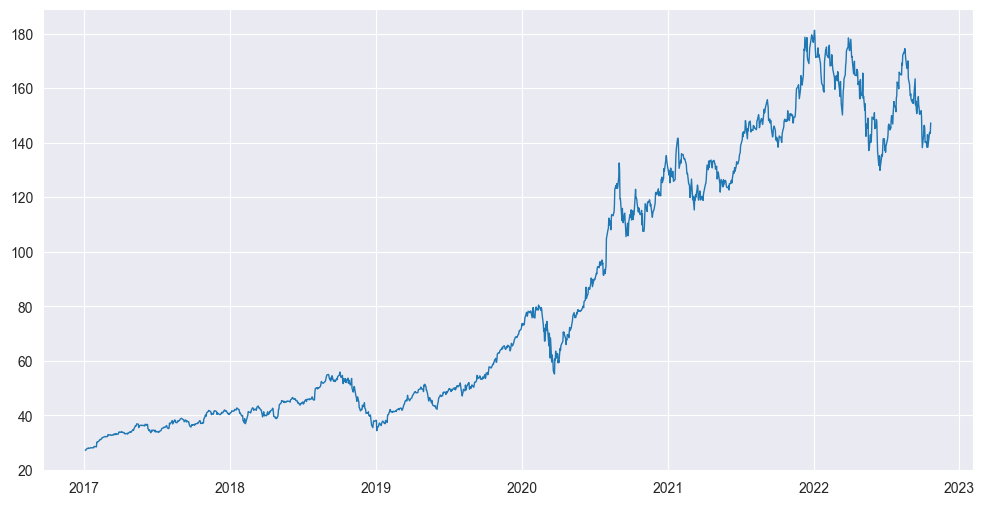

In [173]:
plt.figure(figsize=(12, 6))
plt.plot(apple['DateTime'], apple['Close'], linewidth=1.0)
plt.show()

Первое, что можно сказать про временной ряд: не стационарный (т.к. есть тренд, переменная дисперсия и МО), заметный тренд.

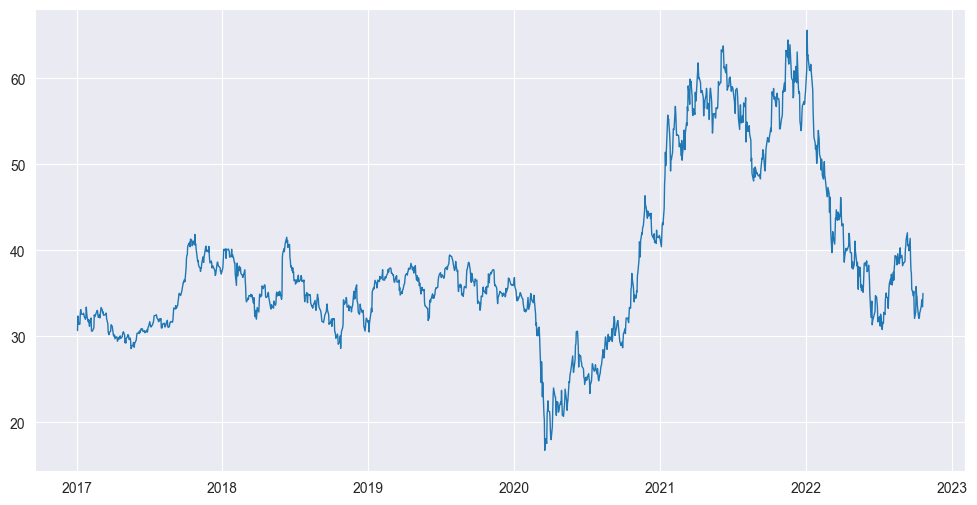

In [174]:
plt.figure(figsize=(12, 6))
plt.plot(general_motors['DateTime'], general_motors['Close'], linewidth=1.0)
plt.show()

Здесь ряд также не стационарный (перменная дисперсия и МО), но тренда как такового нет.

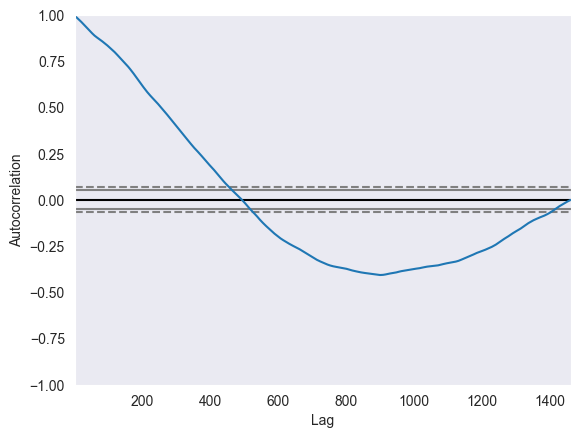

In [175]:
pd.plotting.autocorrelation_plot(apple['Close'])
plt.show()

По данному графику автокорреляции легко видеть, что ряд цен акций эппл на момент закрытия торгов не имеет выраженной сезонности.

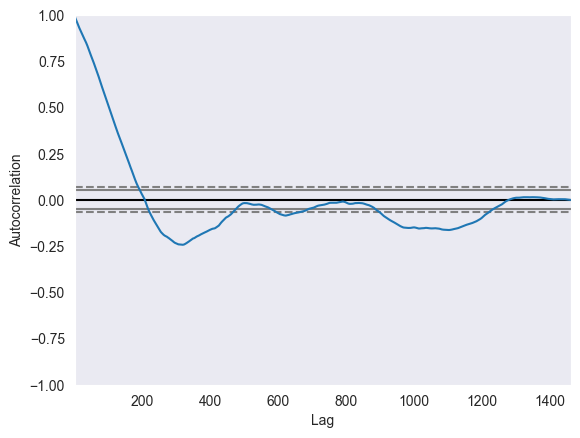

In [176]:
pd.plotting.autocorrelation_plot(general_motors['Close'])
plt.show()

Здесь ситуация несколько отличается, от предыдущего графика, однако по этому графику тоже можно судить об отсутствии сезонности.

In [180]:
def get_statistic(df):
    return f'Mean: {round(df["Close"].mean(), 2)}\n' \
           f'Std: {round(df["Close"].std(), 2)}'

In [181]:
print(get_statistic(apple))

Mean: 84.92
Std: 48.11


In [182]:
print(get_statistic(general_motors))

Mean: 38.49
Std: 9.7


Если посмотреть на моменты первого и второго порядков, то можно увидеть, что ряд эппл куда более вариативный, с довольно высоким среднеквадратичным отклонением, ряд GM наоборот.

Проведем трансформацию, чтобы сделать ряд стационарным:

In [183]:
apple_boxcox, _ = sp.stats.boxcox(apple['Close'])

In [184]:
general_motors_boxcox, _ = sp.stats.boxcox(general_motors['Close'])

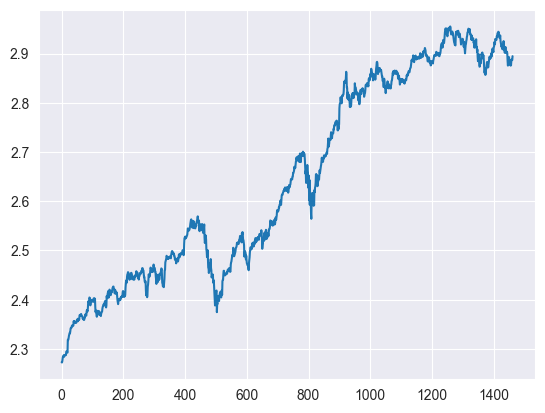

In [186]:
plt.plot(apple_boxcox)
plt.show()

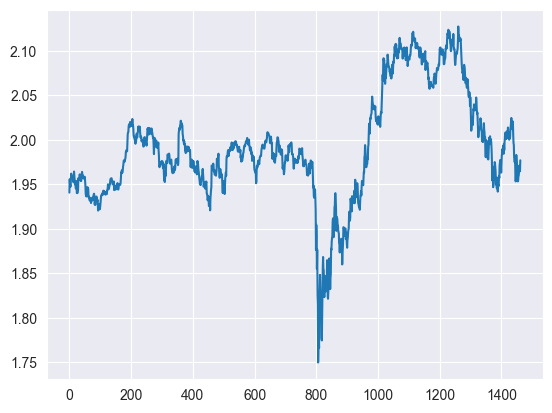

In [188]:
plt.plot(general_motors_boxcox)
plt.show()

Увы, но boxcox трансформация нам не помогла, ряды получились не стационарными.

Попробуем продифференцировать:

In [223]:
apple_diff = apple['Close'].diff()

In [224]:
general_motors_diff = general_motors['Close'].diff()

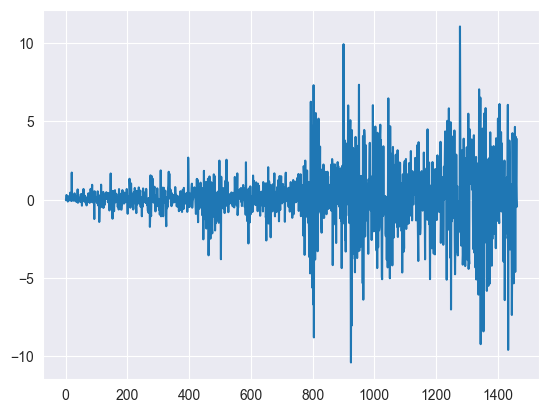

In [225]:
plt.plot(apple_diff)
plt.show()

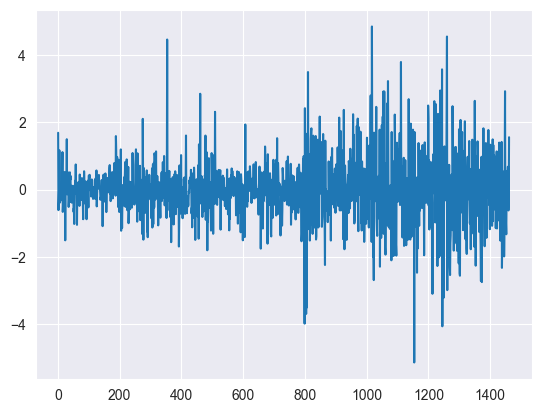

In [226]:
plt.plot(general_motors_diff)
plt.show()

In [227]:
from statsmodels.tsa.stattools import adfuller

In [228]:
adfuller(apple_diff[1:])[1]

2.58650528760509e-12

In [229]:
adfuller(general_motors_diff[1:])[1]

2.683906725045167e-23

Тест Дики-Фуллера для дифференциации обоих рядов с периодом 1 дает значения явно меньше классического 0.05, однако мне не нравится полученный график эппл, т.к. со временем дисперсия вырастает, имеет смысл применить boxcox дабы ее нормализировать, но boxcox'ить уже продифференцированный ряд не получится, т.к. он имеет отрицательные значения, проведем последовательность иначе: продифференцируем уже boxcox'нутый (т.е. сначала нормализируем, а далее избавимся от стационарности):

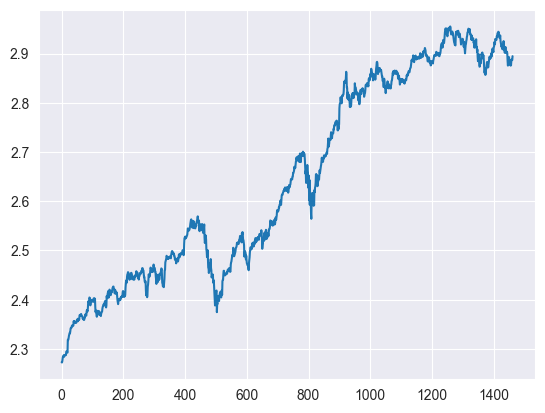

In [230]:
plt.plot(apple_boxcox)

In [231]:
apple_boxcox_diff = pd.Series(apple_boxcox).diff()

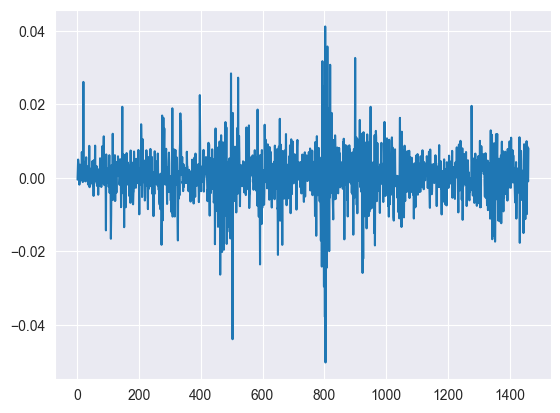

In [232]:
plt.plot(apple_boxcox_diff)
plt.show()

Так гораздо лучше.

Вывод: у обоих рядов отсутствует элемент сезонности, отсутствует гомоскедастичность, но у эппл присутствует явный тренд, в отличие от GM. Дисперсия у эппл крайне изменчива и с течением времени становится только больше, поэтому при дифференциации мы и получили такой вариант: МО постоянно, но дисперсия растет. Однако за счет применения boxcox трансформации ряд стал явно стационарным.